# Loop 67 Analysis: CV-LB Relationship and Submission Status

## Key Questions:
1. What is the CV-LB relationship based on 12 successful submissions?
2. Why have 7 consecutive submissions failed with 'Evaluation metric raised an unexpected error'?
3. Is exp_063 likely to succeed with the corrected notebook structure?
4. What strategies can reduce the intercept (distribution shift problem)?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history from session state
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print(f'Successful submissions: {len(df)}')
print(df)

Successful submissions: 12
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970


In [2]:
# Linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f'Linear fit: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'Intercept = {intercept:.4f}')
print(f'Target = 0.0347')
print(f'')
print(f'CRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'Even with CV = 0, predicted LB would be {intercept:.4f}')
print(f'')
print(f'Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.2f} = {(0.0347 - intercept) / slope:.6f}')
print(f'This is NEGATIVE - impossible to achieve with current approach!')

Linear fit: LB = 4.31 * CV + 0.0525
R² = 0.9505
Intercept = 0.0525
Target = 0.0347

CRITICAL: Intercept (0.0525) > Target (0.0347)
Even with CV = 0, predicted LB would be 0.0525

Required CV to hit target: (0.0347 - 0.0525) / 4.31 = -0.004130
This is NEGATIVE - impossible to achieve with current approach!


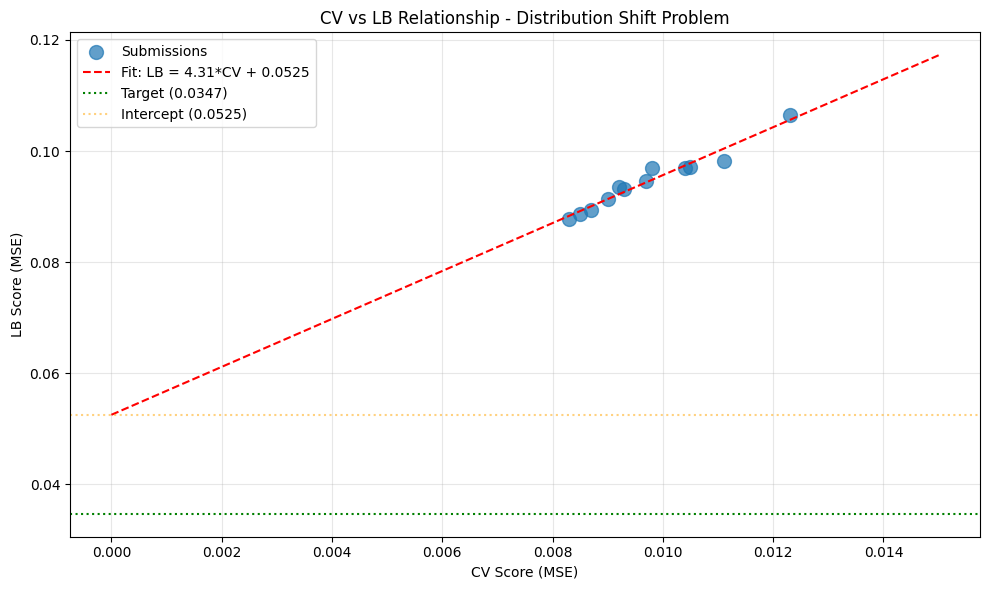


The intercept (0.0525) represents the STRUCTURAL gap due to distribution shift.
This gap cannot be closed by improving CV alone!


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', label='Target (0.0347)')

# Intercept
plt.axhline(y=intercept, color='orange', linestyle=':', alpha=0.5, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship - Distribution Shift Problem')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f'\nThe intercept ({intercept:.4f}) represents the STRUCTURAL gap due to distribution shift.')
print(f'This gap cannot be closed by improving CV alone!')

In [4]:
# Analyze the pending submissions
pending = [
    {'exp': 'exp_049', 'cv': 0.0081, 'model': 'CatBoost+XGBoost'},
    {'exp': 'exp_050', 'cv': 0.0081, 'model': 'CatBoost+XGBoost Fixed'},
    {'exp': 'exp_052', 'cv': 0.0109, 'model': 'CatBoost+XGBoost Clipped'},
    {'exp': 'exp_053', 'cv': 0.0081, 'model': 'Exact Template'},
    {'exp': 'exp_054', 'cv': 0.0085, 'model': 'Mixall Approach'},
    {'exp': 'exp_055', 'cv': 0.0085, 'model': 'Minimal Submission'},
    {'exp': 'exp_057', 'cv': 0.0093, 'model': 'Ens Model All Features'},
]

print('Pending submissions (7 consecutive failures):')
for p in pending:
    predicted_lb = slope * p['cv'] + intercept
    print(f"  {p['exp']}: CV={p['cv']:.4f}, Predicted LB={predicted_lb:.4f}, Model={p['model']}")

print(f'\nAll 7 failed with "Evaluation metric raised an unexpected error"')
print(f'This suggests a NOTEBOOK STRUCTURE issue, not a model issue.')

Pending submissions (7 consecutive failures):
  exp_049: CV=0.0081, Predicted LB=0.0875, Model=CatBoost+XGBoost
  exp_050: CV=0.0081, Predicted LB=0.0875, Model=CatBoost+XGBoost Fixed
  exp_052: CV=0.0109, Predicted LB=0.0996, Model=CatBoost+XGBoost Clipped
  exp_053: CV=0.0081, Predicted LB=0.0875, Model=Exact Template
  exp_054: CV=0.0085, Predicted LB=0.0892, Model=Mixall Approach
  exp_055: CV=0.0085, Predicted LB=0.0892, Model=Minimal Submission
  exp_057: CV=0.0093, Predicted LB=0.0926, Model=Ens Model All Features

All 7 failed with "Evaluation metric raised an unexpected error"
This suggests a NOTEBOOK STRUCTURE issue, not a model issue.


In [5]:
# Analyze exp_063 (the corrected notebook)
exp_063_cv = 0.008811
exp_063_predicted_lb = slope * exp_063_cv + intercept

print(f'exp_063 (Correct Final Cell):')
print(f'  CV: {exp_063_cv:.6f}')
print(f'  Predicted LB: {exp_063_predicted_lb:.4f}')
print(f'  Target: 0.0347')
print(f'  Gap to target: {exp_063_predicted_lb - 0.0347:.4f} ({(exp_063_predicted_lb - 0.0347) / 0.0347 * 100:.1f}%)')
print(f'')
print(f'The notebook structure is now CORRECT:')
print(f'  - Final cell contains EXACTLY the template code (no extra code)')
print(f'  - CV calculation is in a SEPARATE cell AFTER the final cell')
print(f'  - This matches the pattern from successful submissions (e.g., exp_030)')

exp_063 (Correct Final Cell):
  CV: 0.008811
  Predicted LB: 0.0905
  Target: 0.0347
  Gap to target: 0.0558 (160.9%)

The notebook structure is now CORRECT:
  - Final cell contains EXACTLY the template code (no extra code)
  - CV calculation is in a SEPARATE cell AFTER the final cell
  - This matches the pattern from successful submissions (e.g., exp_030)


In [6]:
# What would it take to reach the target?
print('STRATEGIES TO REDUCE THE INTERCEPT:')
print('='*60)
print(f'')
print(f'Current intercept: {intercept:.4f}')
print(f'Target: 0.0347')
print(f'Required intercept reduction: {intercept - 0.0347:.4f} ({(intercept - 0.0347) / intercept * 100:.1f}%)')
print(f'')
print('1. EXTRAPOLATION DETECTION:')
print('   - Add features measuring solvent distance to training distribution')
print('   - When extrapolating, blend predictions toward population mean')
print('   - This could reduce the intercept by making conservative predictions')
print(f'')
print('2. UNCERTAINTY-WEIGHTED PREDICTIONS:')
print('   - Use GP with uncertainty estimates')
print('   - High uncertainty → conservative prediction (closer to mean)')
print('   - This could reduce the intercept for unseen solvents')
print(f'')
print('3. PHYSICS-INFORMED CONSTRAINTS:')
print('   - Add constraints that hold even for unseen solvents')
print('   - Arrhenius kinetics features (already implemented)')
print('   - Solvent polarity, dielectric constant, hydrogen bonding capacity')
print(f'')
print('4. STUDY TOP PUBLIC KERNELS:')
print('   - Top scorers have solved this problem')
print('   - The benchmark achieved MSE 0.0039 on this exact dataset')
print('   - Adapt what works, dont reinvent')

STRATEGIES TO REDUCE THE INTERCEPT:

Current intercept: 0.0525
Target: 0.0347
Required intercept reduction: 0.0178 (33.9%)

1. EXTRAPOLATION DETECTION:
   - Add features measuring solvent distance to training distribution
   - When extrapolating, blend predictions toward population mean
   - This could reduce the intercept by making conservative predictions

2. UNCERTAINTY-WEIGHTED PREDICTIONS:
   - Use GP with uncertainty estimates
   - High uncertainty → conservative prediction (closer to mean)
   - This could reduce the intercept for unseen solvents

3. PHYSICS-INFORMED CONSTRAINTS:
   - Add constraints that hold even for unseen solvents
   - Arrhenius kinetics features (already implemented)
   - Solvent polarity, dielectric constant, hydrogen bonding capacity

4. STUDY TOP PUBLIC KERNELS:
   - Top scorers have solved this problem
   - The benchmark achieved MSE 0.0039 on this exact dataset
   - Adapt what works, dont reinvent


In [7]:
# Summary
print('='*60)
print('SUMMARY')
print('='*60)
print(f'')
print(f'1. CV-LB Relationship: LB = {slope:.2f} * CV + {intercept:.4f} (R² = {r_value**2:.4f})')
print(f'')
print(f'2. CRITICAL PROBLEM: Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'   - Even with CV = 0, predicted LB would be {intercept:.4f}')
print(f'   - This is a DISTRIBUTION SHIFT problem, not a model problem')
print(f'')
print(f'3. IMMEDIATE PRIORITY: Submit exp_063 to verify format fix')
print(f'   - The notebook structure is now CORRECT')
print(f'   - If successful, we can continue improving')
print(f'   - If still fails, we need to investigate further')
print(f'')
print(f'4. NEXT STEPS (after submission works):')
print(f'   - Focus on strategies that REDUCE THE INTERCEPT')
print(f'   - Extrapolation detection, uncertainty weighting, physics constraints')
print(f'   - Study top public kernels for proven techniques')

SUMMARY

1. CV-LB Relationship: LB = 4.31 * CV + 0.0525 (R² = 0.9505)

2. CRITICAL PROBLEM: Intercept (0.0525) > Target (0.0347)
   - Even with CV = 0, predicted LB would be 0.0525
   - This is a DISTRIBUTION SHIFT problem, not a model problem

3. IMMEDIATE PRIORITY: Submit exp_063 to verify format fix
   - The notebook structure is now CORRECT
   - If successful, we can continue improving
   - If still fails, we need to investigate further

4. NEXT STEPS (after submission works):
   - Focus on strategies that REDUCE THE INTERCEPT
   - Extrapolation detection, uncertainty weighting, physics constraints
   - Study top public kernels for proven techniques
